# Insight Project --Birding Big Year--

In this project I intend to determine the cheapest way to win the Big Year competition by the American Birding Association (ABA), following their rules. As part of their rules they give the list of eligible birds (1116).  All the birds have to be seen with in 12:00 AM, January 1st to 11:59 PM, December 31st of the same year. 



In [106]:
import numpy as np
import requests
import ebird.api as eb
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
from pandas.io.json import json_normalize, read_json

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'jpg')

%matplotlib inline

# Our goal

The list of birds from ABA, that have to be found:

In [2]:
dfbirdList = pd.read_csv('./DocumentsHere/Insight/ABA_Checklist-8.0.6a.csv', usecols=[1,3], skiprows=1)
dfbirdList.rename(columns={' including detailed species accounts': 'Bird name', 'Unnamed: 3': '4 letter code'}, inplace=True)
dfbirdList.dropna(inplace=True)
dfbirdList.reset_index(inplace=True)
dfbirdList.drop(['index'], axis=1, inplace=True)

In [3]:
listOfBirds = list(dfbirdList['Bird name'].unique())

# Now the weather data

The weather data is colected using an API form meteostat.  I might need to move to use the NOAA sight directly in the future. 

In [117]:
a = requests.get("https://api.meteostat.net/v1/history/daily?station=72577&start=2019-01-01&end=2019-12-31&key=xxx")

In [120]:
 yearWeather = json_normalize(a.json()['data'])

In [121]:
 yearWeather

,date,temperature,temperature_min,temperature_max,precipitation,snowfall,snowdepth,winddirection,windspeed,peakgust,sunshine,pressure
0,2019-01-01,-23.4,-16.6,-8.2,0.0,None,None,NaN,6.8,None,None,1037.2
1,2019-01-02,-20.0,-16.3,-5.8,NaN,None,None,NaN,6.2,None,None,1040.2
2,2019-01-03,-14.8,-16.4,-5.3,NaN,None,None,NaN,3.3,None,None,1036.6
3,2019-01-04,-14.4,-14.3,-2.9,NaN,None,None,NaN,5.3,None,None,NaN
4,2019-01-05,-11.7,-13.6,-1.5,1.7,None,None,NaN,NaN,None,None,1025.2
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2019-12-27,-12.6,-11.3,-3.4,NaN,None,None,NaN,4.7,None,None,1023.0
360,2019-12-28,-14.9,-10.2,-2.9,0.0,None,None,NaN,7.4,None,None,1025.7
361,2019-12-29,-16.2,-13.6,-4.5,0.7,None,None,NaN,6.0,None,None,1029.1
362,2019-12-30,-20.7,-13.2,-2.5,0.3,None,None,NaN,NaN,None,None,NaN


In [115]:
w = requests.get('https://api.meteostat.net/v1/stations/search?q=jackson&key=xxx')
y = json_normalize(w.json()['data'])
    


In [116]:
y

,id,country,name
0,72219,US,Hartsfield-Jackson Atlanta
1,72206,US,Jacksonville International
2,72235,US,Jackson Airport
3,72419,US,Jackson / Northwest Hills
4,72577,US,Jackson Hole / Moose


# Now the bird Data

I will start with a singe state the State of WY. In all situation the predictions will only use the last two years of data.

Since the ebird API limits the type of request I can make, I have a downloaded cvs file.

In [4]:
dfAll = pd.read_csv('./DocumentsHere/Insight/ebd_US-WY_201801_201912_relApr-2020/ebd_US-WY_201801_201912_relApr-2020.txt'
                ,delimiter="\t")

I add sertain condition to satify completnes fo the data, public locations and only bird species (i.e. no hybirds)

In [5]:
dfAll = dfAll[(dfAll['CATEGORY'] == 'species') & (dfAll['LOCALITY TYPE'] == 'H')
              & (dfAll['ALL SPECIES REPORTED'] == 1)  & (dfAll['APPROVED'] == 1)]

In [6]:
dfReduce = dfAll.filter(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'LOCALITY', 'TIME OBSERVATIONS STARTED',
              'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'ALL SPECIES REPORTED']) 
dfReduce['YEAR DAY'] = list(map(lambda x: int(datetime.strptime(x, '%Y-%m-%d').date().strftime('%j')), dfReduce['OBSERVATION DATE']))

In [39]:
def birds_on_day(date, df, drange = 7):
    '''
    Calculates the probability of observation based on the last 2 years of observations on a given day with some 
    days average given by 'drange'
    
    Inputs:
    date: int, or string with format "mm-dd", int is the day number of the year.
    drange: smoothing kernel, default 7 days. This is to garantee a larger nomber of observations.
    df: the input dataframe.
    
    Output:
    
    df3: is a dataframe with the provabilty of seeing each bird specie at a given location.  Is fixed in time.
    '''

    if isinstance(date, str):
        date = int(datetime.strptime(date, '%m-%d').date().strftime('%j'))
        
    n0 = date-drange//2
    n1 = date+drange//2
    
    #The kernel is modify if is at the edge of the calendar year:
    
    if n0 < 0:
        n1 = n1 - n0
        n0 = 0
    if n1 > 365:
        n0 = n0-(365-n1)
        n1 = 364
    
    df = df.loc[(df['YEAR DAY'] >= n0) & (df['YEAR DAY'] <= n1)]
    
    df1 = df.set_index(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'YEAR DAY', 'LOCALITY'])
    df1 = df1.groupby(['COMMON NAME', 'LOCALITY']).sum()
    df1 = df1.reset_index()
    
    
    df2 = df.set_index(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'YEAR DAY', 'LOCALITY'])
    df2 = df2.groupby(['LOCALITY']).sum()
    df2.reset_index(inplace=True)
    
    df3 = df1.merge(df2, left_on='LOCALITY', right_on='LOCALITY')
    df3 = df3.reset_index()
    df3['POSITIVE OBS'] = df3['ALL SPECIES REPORTED_x']/df3['ALL SPECIES REPORTED_y']
    df3.drop(['index', 'LATITUDE_x', 'LONGITUDE_x', 'LATITUDE_y', 'LONGITUDE_y', 
              'ALL SPECIES REPORTED_x', 'ALL SPECIES REPORTED_y'], axis=1, inplace=True)
    
    df.drop(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'TIME OBSERVATIONS STARTED', 'OBSERVATION DATE',
              'ALL SPECIES REPORTED', 'YEAR DAY'], axis=1, inplace=True)
    
    df3 = df3.merge(df, left_on='LOCALITY', right_on='LOCALITY', how = 'left')
    
    return df3.drop_duplicates()


In [110]:
day = '01-29'
bidsOut = birds_on_day(day, dfReduce, drange = 7)

/Users/casanova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [111]:
bidsOut.head(5)

,COMMON NAME,LOCALITY,POSITIVE OBS,LATITUDE,LONGITUDE
0,American Crow,Cheyenne--Holliday Park,0.250000,41.139235,-104.802897
4,Eurasian Collared-Dove,Cheyenne--Holliday Park,0.250000,41.139235,-104.802897
8,House Finch,Cheyenne--Holliday Park,0.250000,41.139235,-104.802897
12,House Sparrow,Cheyenne--Holliday Park,0.250000,41.139235,-104.802897
16,American Crow,Cheyenne--Lions Park,0.172414,41.159070,-104.831009


# Is time for some plots!

In [112]:
country = gpd.read_file('./DocumentsHere/Insight/gz_2010_us_040_00_5m.json')

In [113]:
bidName = 'American Crow'
state = 'Wyoming'

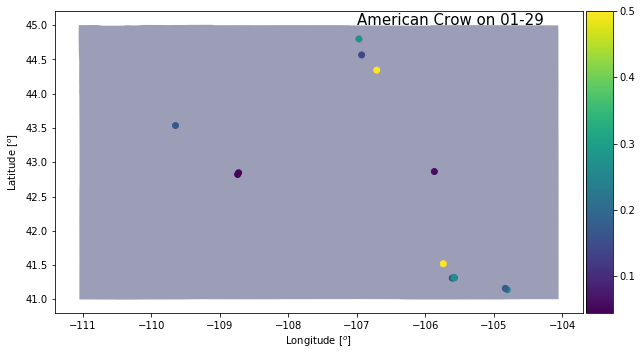

In [114]:
fig, ax = plt.subplots(1, figsize=(10,15))
base = country[country['NAME'].isin([state]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.5)
im = ax.scatter(bidsOut[bidsOut['COMMON NAME'] == bidName]['LONGITUDE'],
           bidsOut[bidsOut['COMMON NAME'] == bidName]['LATITUDE'],
          c = list(bidsOut[bidsOut['COMMON NAME'] == bidName]['POSITIVE OBS']))
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')

plt.text(-107, 45.01, r'{} on {}'.format(bidName,day), color='k',size=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax = cax, orientation='vertical')

plt.show()
save_fig('./DocumentsHere/Insight/{}{}{}.jpg'.format(state,bidName,day))
